In [25]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [47]:
def meters2grid(pose_m, nx=100, ny=100, nz=100):
    # [0, 0, 0](m) -> [250, 250, 0]
    # [1, 0, 0](m) -> [250+100, 250, 0]
    # [0,-1, 0](m) -> [250, 250-100]
    # [0, 0, 1](m) -> [250, 250, 100]
    pose_on_grid = np.array(pose_m)*100 + np.array([nx/2, ny/2, 0])
    return np.array( pose_on_grid, dtype=int)

In [46]:
def grid2meters(pose_grid, nx=100, ny=100):
    # [250, 250, 0] -> [0, 0, 0](m)
    # [250+100, 250, 0] -> [1, 0, 0](m)
    # [250, 250-100, 100] -> [0,-1, 1](m)
    pose_meters = ( np.array(pose_grid) - np.array([nx/2, ny/2, 0]) ) / 100.0
    return pose_meters

In [87]:
start = np.array([0.0, 0.0, 0.0])
goal =  np.array([0.0, 0.5, 0.0])

nx = 100; ny = 100; nz = 300
x,y,z = np.meshgrid(np.arange(nx), np.arange(ny), np.arange(nz))
xi = 1./700
attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 + (z - goal[2])**2 )

f = attractive
gy, gx, gz = np.gradient(-f)

[ 0.  -0.5  0. ]
[ 0.  -0.6  0. ]
[ 0.  -0.7  0. ]
[ 0.  -0.8  0. ]


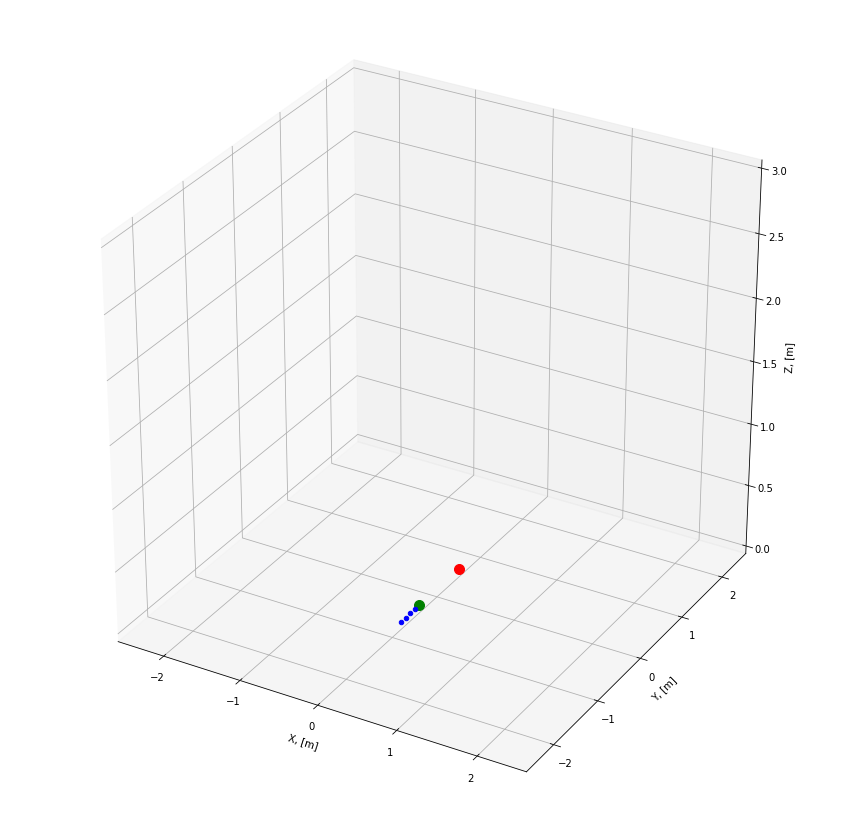

In [93]:
def plot_point3D(p, color='blue'):
    ax.scatter3D(p[0], p[1], p[2], color=color)

# init_fonts()
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
ax.set_xlabel('X, [m]')
ax.set_ylabel('Y, [m]')
ax.set_zlabel('Z, [m]')
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_zlim([0.0, 3.0])

# Start and goal positions
ax.scatter3D(start[0], start[1], start[2], color='green', s=100)
ax.scatter3D(goal[0], goal[1], goal[2], color='red', s=100)

p = start

for i in range(4):
    ix, iy, iz = np.array( meters2grid(p), dtype=int )
    vx = 0#gx[ix, iy, iz] 
    vy = gz[ix, iy, iz] 
    vz = 0#gz[ix, iy, iz] 
    V = np.array([vx, vy, vz])
    dt = 0.1 / norm(V) if norm(V)!=0 else 0.1
    p += dt*V
    print(p)
    plot_point3D(p)

plt.show() 

In [ ]:
def combined_potential(obstacles_poses, R_obstacles, goal, influence_radius=2, attractive_coef=1./700, repulsive_coef=200, nrows=500, ncols=500):
    """ Repulsive potential """
    obstacles_map = map(obstacles_poses, R_obstacles)
    goal = meters2grid(goal)
    d = bwdist(obstacles_map==0)
    d2 = (d/100.) + 1 # Rescale and transform distances
    d0 = influence_radius
    nu = repulsive_coef
    repulsive = nu*((1./d2 - 1./d0)**2)
    repulsive [d2 > d0] = 0
    """ Attractive potential """
    [x, y] = np.meshgrid(np.arange(ncols), np.arange(nrows))
    xi = attractive_coef
    attractive = xi * ( (x - goal[0])**2 + (y - goal[1])**2 )
    """ Combine terms """
    f = attractive + repulsive
    return f

In [ ]:
def gradient_planner(f, current_point, ncols=500, nrows=500, movement_speed=0.06):
    """
    GradientBasedPlanner : This function computes the next_point
    given current location, goal location and potential map, f.
    It also returns mean velocity, V, of the gradient map in current point.
    """
    [gy, gx] = np.gradient(-f);
    iy, ix = np.array( meters2grid(current_point), dtype=int )
    w = 20 # smoothing window size for gradient-velocity
    vx = np.mean(gx[ix-int(w/2) : ix+int(w/2), iy-int(w/2) : iy+int(w/2)])
    vy = np.mean(gy[ix-int(w/2) : ix+int(w/2), iy-int(w/2) : iy+int(w/2)])
    V = np.array([vx, vy])
    dt = movement_speed / norm(V);
    next_point = current_point + dt*V;
    return next_point, V
